In [56]:
import os  # Для работы с файловой системой
import sep  # Для извлечения и анализа источников на астрономических изображениях
import pandas as pd  # Для работы с таблицами данных
import matplotlib.pyplot as plt  # Для построения графиков и визуализации данных
from astropy.io import fits  # Для чтения и записи FITS файлов, стандартного формата астрономических данных
from astropy.wcs import WCS  # Для работы с мировой координатной системой (WCS) в астрономических изображениях
from matplotlib.patches import Circle  # Для рисования кругов на графиках
import numpy as np  # Для работы с массивами чисел и выполнения численных операций
from scipy.stats import norm  # Для работы со статистическим нормальным распределением
from scipy.optimize import curve_fit
from astropy.stats import sigma_clipped_stats  # Для расчета статистик с исключением выбросов (сигма-клиппинг)
from mpl_toolkits.axes_grid1 import make_axes_locatable  # Для создания делимых областей на графиках
from concurrent.futures import ThreadPoolExecutor  # Для параллельного выполнения задач
from astropy.visualization import ZScaleInterval, MinMaxInterval  # Для масштабирования изображений
import time
from tqdm import tqdm
from astroquery.gaia import Gaia
from scipy.ndimage import gaussian_filter
import cv2
from concurrent.futures import ThreadPoolExecutor
from astropy.table import Table
import astropy.units as u

from astropy.coordinates import SkyCoord 

In [76]:
def calc_frame_radius(header):
    """
    Вычисляет радиус окружности, описанной вокруг изображения, используя WCS-информацию из заголовка FITS.

    Параметры:
    -----------
    header : astropy.io.fits.Header
        Заголовок FITS-файла, содержащий WCS-информацию.

    Возвращает:
    -----------
    radius : float
        Радиус окружности, описанной вокруг изображения, в градусах.
    """

    # Создаем WCS объект на основе заголовка
    wcs = WCS(header)
    
    # Определяем размер изображения по осям
    naxis1 = header['NAXIS1']
    naxis2 = header['NAXIS2']
    
    # Координаты углов изображения в пикселях
    corners = np.array([
        [0, 0],
        [0, naxis2 - 1],
        [naxis1 - 1, 0],
        [naxis1 - 1, naxis2 - 1]
    ])
    
    # Преобразуем пиксельные координаты углов в экваториальные координаты (RA, Dec)
    ra_dec_corners = wcs.all_pix2world(corners, 1)
    
    # Получаем координаты центра изображения в пикселях
    center_pixel = np.array([[naxis1 / 2, naxis2 / 2]])
    
    # Преобразуем координаты центра в экваториальные координаты (RA, Dec)
    ra_dec_center = wcs.all_pix2world(center_pixel, 1)[0]
    
    # Вычисляем расстояние от центра до каждого из углов (в градусах)
    distances = np.sqrt((ra_dec_corners[:, 0] - ra_dec_center[0])**2 + 
                        (ra_dec_corners[:, 1] - ra_dec_center[1])**2)
    
    # Радиус окружности — это максимальное расстояние от центра до угла
    radius = np.max(distances)

    return radius


def match_stars(header, objects_df, output_directory=".", file_base_name="unknown"):
    """
    Сопоставляет координаты звезд из FITS-файла с каталогом Gaia на основе центральных координат изображения и заданного радиуса.
    Вычисляет разницу между координатами объектов и найденными совпадениями в каталоге Gaia.
    Строит графики разницы координат по осям RA и Dec, а также визуализирует исходные и совпавшие данные.
    """

    # Перевод радиуса в градусы
    radius = calc_frame_radius(header)

    # Получение центральных координат из заголовка FITS файла
    ra_center = header['CRVAL1']
    dec_center = header['CRVAL2']

    # Создание объекта SkyCoord для центральных координат
    coord = SkyCoord(ra=ra_center, dec=dec_center, unit=(u.degree, u.degree), frame='icrs')
    Gaia.ROW_LIMIT = 1000000 
    # Выполнение конического поиска в каталоге Gaia
    j = Gaia.cone_search_async(coord, radius=u.Quantity(radius, u.deg))
    gaia_df = j.get_results().to_pandas()

    # Создание SkyCoord объектов для сопоставления
    objects_coords = SkyCoord(ra=objects_df['ra'].values, dec=objects_df['dec'].values, unit='deg')
    gaia_coords = SkyCoord(ra=gaia_df['ra'].values, dec=gaia_df['dec'].values, unit='deg')

    # Сопоставление координат объектов с каталогом Gaia
    idx, d2d, _ = objects_coords.match_to_catalog_sky(gaia_coords)

    # Получение данных о совпавших звездах
    matched_stars = gaia_df.iloc[idx].copy()

    # Вычисление разницы координат
    objects_df['ra_diff'] = objects_df['ra'].values - matched_stars['ra'].values
    objects_df['dec_diff'] = objects_df['dec'].values - matched_stars['dec'].values

    # Построение графиков разницы координат по осям
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    axs[0].scatter(objects_df['x'],objects_df['ra_diff'] * 3600,  s=1)
    axs[0].set_xlabel("X coordinate")
    axs[0].set_ylabel("RA Difference (arcsec)")
    axs[0].set_title("RA Difference vs X coordinate")
    axs[0].grid(True)

    axs[1].scatter(objects_df['y'], objects_df['dec_diff'] * 3600,  s=1)
    axs[1].set_xlabel("Y coordinate")
    axs[1].set_ylabel("Dec Difference (arcsec)")
    axs[1].set_title("Dec Difference vs Y coordinate")
    axs[1].grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, file_base_name + "_coords_err.png"), bbox_inches='tight', pad_inches=0, dpi=300)
    plt.show()

    # Построение графиков для визуализации исходных данных и совпадений
    fig, axs = plt.subplots(figsize=(8, 4))
    
    axs.scatter(objects_df['ra'], objects_df['dec'], s=2, color="steelblue", alpha=0.5, label="Frame")
    axs.scatter(gaia_df['ra'], gaia_df['dec'], s=2, color="green", alpha=0.5, label="Gaia DR3")
    axs.scatter(matched_stars['ra'], matched_stars['dec'], s=1, color="red", alpha=0.5, label="Match")
    
    axs.set_ylabel("DEC (degrees)")
    axs.set_xlabel("RA (degrees)")
    axs.set_title("Matched objects")
    axs.grid(True)
    axs.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, file_base_name + "_matched_plot.png"), bbox_inches='tight', pad_inches=0, dpi=300)
    plt.show()

    # Сохранение результатов в файл (если необходимо)
    # output_file = f"{output_directory}/{file_base_name}_matched.csv"
    # objects_df.to_csv(output_file, index=False)

    return objects_df
    
def plot_matching_errors(matches_df, header, output_directory=".", file_base_name="unknown"):
    """
    Отображает ошибки сопоставления координат (разница между RA и Dec) в виде графиков.

    Параметры:
    matches_df : pandas.DataFrame
        DataFrame с колонками 'ra_diff', 'dec_diff', 'x', 'y'.
    header : astropy.io.fits.Header
        Заголовок FITS файла для определения соответствия осей координат.
    """

    # Определение типа координат по осям
    x_label = "RA Difference" if "RA" in header['CTYPE1'] else "Dec Difference"
    y_label = "RA Difference" if "RA" in header['CTYPE2'] else "Dec Difference"

    # Построение графиков разницы координат по осям
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    axs[0].scatter( matches_df['ra_diff']*3600, matches_df['x'], s=1)
    axs[0].set_ylabel("X coordinate")
    axs[0].set_xlabel(x_label +" (arcsec)")
    axs[0].set_title("RA Difference vs X coordinate")
    axs[0].grid(True)

    axs[1].scatter(matches_df['dec_diff']*3600, matches_df['y'], s=1)
    axs[1].set_ylabel("Y coordinate")
    axs[1].set_xlabel(y_label +" (arcsec)")
    axs[1].set_title("Dec Difference vs Y coordinate")
    axs[1].grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, file_base_name+"_coords_err.png"), bbox_inches='tight', pad_inches=0, dpi=300)
    plt.show()

In [49]:
file_name = "/home/izm-ildana/astro/variable_search/data/alf-Cyg_20-21.10.1985_20m_77S-77986.fit"
hdul = fits.open(file_name)
data = hdul[0].data
header = hdul[0].header

In [50]:
objects_df = pd.read_csv("/home/izm-ildana/astro/variable_search/output/alf-Cyg_20-21.10.1985_20m_77S-77986.csv")

In [68]:
Gaia.login(user='iizmailo', password='casio.FX-220')

INFO: Login to gaia TAP server [astroquery.gaia.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Login to gaia data server [astroquery.gaia.core]
INFO: OK [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


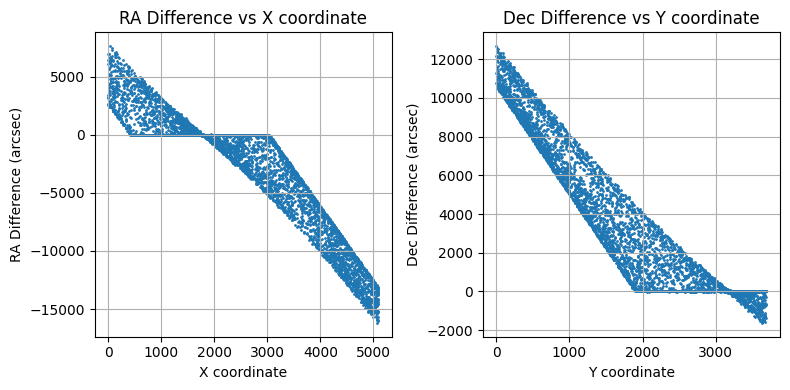

/tmp/ipykernel_14943/2913838302.py:117: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_14943/2913838302.py:118: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(os.path.join(output_directory, file_base_name + "_matched_plot.png"), bbox_inches='tight', pad_inches=0, dpi=300)
/home/izm-ildana/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


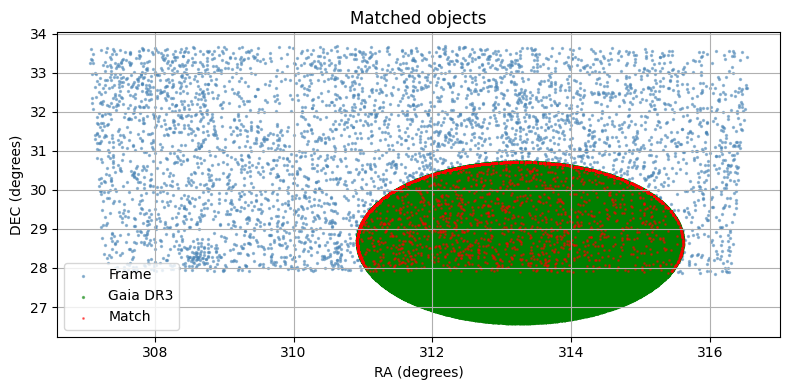

Время выполнения функции: 940.45 секунд


In [77]:
import time

# Засекаем время перед выполнением функции
start_time = time.time()

# Выполняем функцию
matches_df = match_stars(header, objects_df, output_directory="/home/izm-ildana/astro/variable_search/output", file_base_name="alf-Cyg_20-21.10.1985_20m_77S-77986")

# Засекаем время после выполнения функции
end_time = time.time()

# Вычисляем и выводим затраченное время
elapsed_time = end_time - start_time
print(f"Время выполнения функции: {elapsed_time:.2f} секунд")


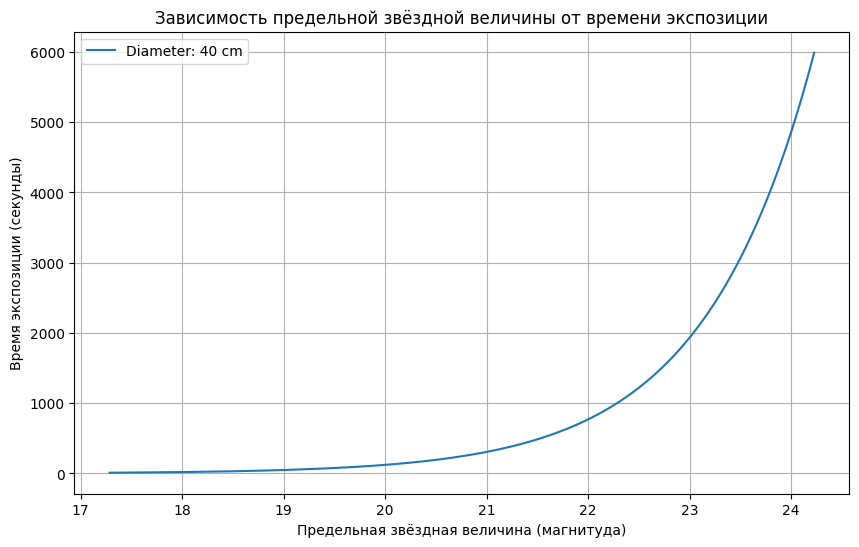

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_magnitude(diameter_telescope, diameter_eye, exposure_time):
    m_eye = 6  # предельная звёздная величина для глаза
    # Рассчитываем магнитуду
    magnitude = m_eye + 5 * np.log10(diameter_telescope / diameter_eye) + 2.5 * np.log10(exposure_time)
    return magnitude

# Параметры телескопа
diameter_telescope = 40  # диаметр телескопа в см
diameter_eye = 0.7  # диаметр зрачка глаза в см (7 мм)

# Диапазон времени экспозиции от 1 секунды до 10000 секунд
exposure_times = np.logspace(10, 4, 100)
exposure_times = np.arange(10,6000,10)
# Вычисляем магнитуду для каждого значения времени экспозиции
magnitudes = calculate_magnitude(diameter_telescope, diameter_eye, exposure_times)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(magnitudes,exposure_times,  label=f'Diameter: {diameter_telescope} cm')
# plt.xscale('log')
plt.ylabel('Время экспозиции (секунды)')
plt.xlabel('Предельная звёздная величина (магнитуда)')
plt.title('Зависимость предельной звёздной величины от времени экспозиции')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
import csv

# Указанные пути к файлам
input_file_path = '/home/izm-ildana/astro/variable_search/output/ds9.reg'
output_file_path = '/home/izm-ildana/astro/variable_search/output/output_coordinates.csv'

# Функция для извлечения координат из строки
def extract_coordinates(line):
    # Проверяем наличие 'fk5' и '(' в строке
    if 'fk5' in line and '(' in line and ')' in line:
        try:
            parts = line.split('(')[1].split(')')[0]  # Извлекаем строку между скобками
            ra, dec = parts.split(',')
            return float(ra), float(dec)
        except (IndexError, ValueError):
            # Если возникают ошибки при извлечении или преобразовании координат, возвращаем None
            return None, None
    return None, None

# Открываем исходный файл и создаем CSV файл
with open(input_file_path, 'r') as infile, open(output_file_path, 'w', newline='') as outfile:
    reader = infile.readlines()
    writer = csv.writer(outfile)
    
    # Записываем заголовки
    writer.writerow(['RA (degrees)', 'DEC (degrees)'])
    
    # Обрабатываем строки файла и записываем координаты в CSV
    for line in reader:
        ra, dec = extract_coordinates(line)
        if ra is not None and dec is not None:
            writer.writerow([ra, dec])

print(f"CSV файл создан: {output_file_path}")


CSV файл создан: /home/izm-ildana/astro/variable_search/output/output_coordinates.csv


In [14]:
import csv

# Функция для перевода прямого восхождения (RA) из часов в градусы
def ra_to_degrees(ra):
    hours, minutes, seconds = map(float, ra.split(':'))
    return (hours + minutes / 60 + seconds / 3600) * 15

# Функция для перевода склонения (DEC) из формата "градусы:минуты:секунды" в градусы
def dec_to_degrees(dec):
    degrees, minutes, seconds = map(float, dec.split(':'))
    return degrees + minutes / 60 + seconds / 3600

# Указанные пути к файлам
input_file_path = '/home/izm-ildana/astro/variable_search/output/ds9.reg'
output_file_path = '/home/izm-ildana/astro/variable_search/output/output_coordinates.csv'

# Открытие исходного файла и создание CSV файла
with open(input_file_path, 'r') as infile, open(output_file_path, 'w', newline='') as outfile:
    reader = infile.readlines()
    writer = csv.writer(outfile)
    
    # Записываем заголовки в CSV
    writer.writerow(['RA (degrees)', 'DEC (degrees)'])
    
    # Обрабатываем строки файла начиная с 4-й строки
    for i, line in enumerate(reader, start=1):
        if i >= 4:
            # Извлечение координат из строки
            try:
                coords_part = line.split('(')[1].split(')')[0]
                ra, dec = coords_part.split(',')[0], coords_part.split(',')[1]
                
                # Преобразование RA и DEC в градусы
                ra_degrees = ra_to_degrees(ra.strip())
                dec_degrees = dec_to_degrees(dec.strip())
                
                # Запись координат в CSV
                writer.writerow([ra_degrees, dec_degrees])
            except (IndexError, ValueError):
                # Обработка возможных ошибок извлечения и преобразования
                continue

print(f"CSV файл создан: {output_file_path}")

CSV файл создан: /home/izm-ildana/astro/variable_search/output/output_coordinates.csv


In [43]:
from astropy.io import fits 
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    'figure.figsize': (8, 6),  # Размеры графиков
    'figure.dpi': 100,  # Разрешение графиков
    'savefig.dpi': 300,  # Разрешение сохраненных изображений
    'font.size': 12,  # Размер шрифта
    'font.family': 'serif',  # Семейство шрифтов
    'axes.labelsize': 14,  # Размер шрифта для подписей осей
    'axes.titlesize': 14,  # Размер шрифта для заголовков
    'xtick.labelsize': 12,  # Размер шрифта для подписей меток на оси X
    'ytick.labelsize': 12,  # Размер шрифта для подписей меток на оси Y
    'legend.fontsize': 10,  # Размер шрифта для легенды
    'lines.linewidth': 1,  # Толщина линий
    'lines.markersize': 6,  # Размер маркеров
    'axes.grid': False,  # Сетка на графиках
    'grid.alpha': 0.25,  # Прозрачность сетки
    'grid.linestyle': '--',  # Стиль линии сетки
    'grid.color': 'gray',  # Цвет сетки
    'axes.axisbelow': True,  # Сетка ниже данных
    'image.cmap': 'viridis',  # Цветовая карта для изображений
    'errorbar.capsize': 3,  # Размер "колпачков" на графиках ошибок
    "legend.loc": 'best', 
})

In [19]:
input_file_path = '/home/izm-ildana/astro/variable_search/output/alf-Cyg_20-21.10.1985_20m_77S-77986match_53obj_35arcsec.fits'

hdul = fits.open(input_file_path)
data = hdul[1].data
header = hdul[1].header

In [29]:
df = pd.DataFrame(hdul[1].data)

In [31]:
df.columns

Index(['id', 'x', 'y', 'ra_1', 'dec_1', 'flux', 'flux_err', 'mag', 'mag_err',
       'flag', 'a', 'b', 'source_id', 'ra_2', 'ra_error', 'dec_2', 'dec_error',
       'Separation', 'delta_ra', 'delta_dec'],
      dtype='object')

In [44]:
# Создание субплотов
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# График dif_ra против x
ax1.scatter( df['delta_ra']*3600, df['x'], marker='o', linestyle='-', color='b', label='dif_ra vs x')
ax1.set_ylabel('X (physic coordinates)')
ax1.set_xlabel('delta_ra')
ax1.set_title('Dif_RA vs X')
# ax1.tick_params(axis='x', rotation=45)
ax1.grid(True)
# ax1.legend()

# График dif_dec против x
ax2.scatter( df['delta_dec']*3600,df['y'], marker='o', linestyle='-', color='r', label='dif_dec vs x')
ax2.set_ylabel('Y (physic coordinates)')
ax2.set_title(r'$\Delta$ DEC')
ax2.set_title('Dif_DEC vs X')
# ax2.tick_params(axis='x', rotation=45)
ax2.grid(True)
# ax2.legend()

# Отображение графиков
plt.tight_layout()
plt.show()

RuntimeError: Failed to process string with tex because latex could not be found

Error in callback <function _draw_all_if_interactive at 0x7fe71d126700> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 800x400 with 2 Axes>